In [1]:
!pip install --upgrade --upgrade-strategy eager recap-utils

Requirement already up-to-date: recap-utils in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (0.1.0)
Requirement already up-to-date: click-pathlib<2020.0.0,>=2019.12.28 in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (from recap-utils) (2019.12.28.7)
Requirement already up-to-date: recap-argument-graph<0.2.0,>=0.1.0 in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (from recap-utils) (0.1.16)
Requirement already up-to-date: recap-argument-graph-translator<0.2.0,>=0.1.1 in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (from recap-utils) (0.1.5)
Requirement already up-to-date: click<8.0,>=7.0 in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (from recap-utils) (7.0)
Requirement already up-to-date: tomlkit<0.6.0,>=0.5.8 in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (from recap-utils) (0.5.8)
Requirement already up-to-date

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install -U recap_argument_graph

Requirement already up-to-date: recap_argument_graph in c:\users\premtim\appdata\local\programs\python\python38\lib\site-packages (0.1.16)


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
from recap_argument_graph import Graph, Node, Edge, NodeCategory

In [8]:
def parser(input):

    # Read lines of the text File.
    lines = []
    with open(input, "r", encoding="utf8") as file:
        for line in file:
            lines.append(line.strip("\n"))

    # Remove first two lines of document since Discussion Title and the second lines do not contain necessary information.
    trash, title = lines[0].split("Discussion Title: ", maxsplit=1)
    print(title)
    lines = lines[2:]
    level, mc_text = lines[0].split(" ", maxsplit=1)
    # Remove major claim
    lines = lines[1:]
 
    # delete lines that do not have levels on them, future TODO: add lines to last element with level in chat
    delete_positions = []
    for i, line in enumerate(lines):
        if line[:2] != "1.":
            delete_positions.append(i)
        elif line[:3] == "1. ":
            delete_positions.append(i)

    # construct processing information
    node_info = {}
    
    for i, line in enumerate(lines):
        if i in delete_positions:
            continue
        level, stance, text = line.split(" ", maxsplit=2)
        node_info[level] = [stance[:-1], text]

    # resolve references in data    
    for level, [stance, text] in node_info.items():
        if "-> See" in text:
            trash, reference = text.split(sep="See ")
            if "discussion" in reference:
                discussion_reference, discussion_title = reference.split(": ")
                node_info[level][1] = discussion_title
            else:
                node_info[level][1] = node_info[reference][1]
    
    # create graph and add major claim node to Graph 
    graph = Graph(name = title); level_node_mappings = {}
    mc_node = Node(key = graph.keygen(), text=mc_text, category=NodeCategory("I"), major_claim=True, participant_id=0)
    graph.add_node(mc_node); level_node_mappings["1."] = mc_node
    
    for level, [stance, text] in node_info.items():
        # get parent node level information
        parent_level, trash = level[:-1].rsplit(sep=".", maxsplit=1)
        parent_level += "."
        parent_node = level_node_mappings[parent_level]
        
        # create SCHEME NODE that connects child to parent
        scheme_key = graph.keygen()
        scheme_node = Node(key = scheme_key,
                           text = "Support" if stance == "Pro" else "Attack",
                           category = NodeCategory("RA" if stance == "Pro" else "CA"),
                           participant_id=0)
        graph.add_node(scheme_node)
        
        # create CHILD NODE 
        child_key = graph.keygen()
        child_node = Node(key = child_key,
                          text = text,
                          category = NodeCategory("I"), 
                          participant_id=0)
        graph.add_node(child_node); level_node_mappings[level] = child_node
        
        
        # create EDGES: child --> scheme, scheme --> parent
        edge_key_c2s = graph.keygen()
        child2scheme_edge = Edge(key=edge_key_c2s, start = child_node, end = scheme_node)
        graph.add_edge(child2scheme_edge)
        
        # create EDGES: scheme --> parent
        edge_key_s2p = graph.keygen()
        scheme2parent_edge = Edge(key = edge_key_s2p, start = scheme_node, end = parent_node)
        graph.add_edge(scheme2parent_edge)
        
    return graph

In [27]:
g = parser("god_example.txt")

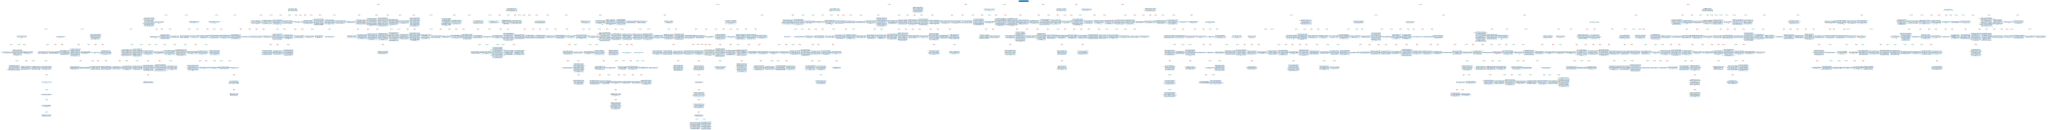

In [28]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
g.to_gv()#.render(filename='prem')

In [32]:
from pathlib import Path
g.save(Path("test3.json"))

In [33]:
graph_import = Graph.open(Path("test3.json"))

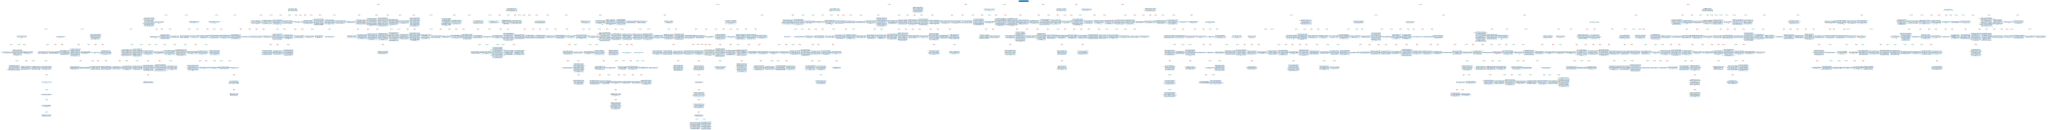

In [34]:
graph_import.to_gv()

In [22]:
import glob, json
from pathlib import Path
files = glob.glob("kialo_deutsch/*.txt")

In [23]:
files[0]

'kialo_deutsch\\bedingungsloses-grundeinkommen-pro-und-contra-31355.txt'

In [24]:
for i, file in enumerate(files):
        graph = parser(file)
        trash, file_name_txt = file.split(sep = "\\", maxsplit = 1)
        file_name, dottxt = file_name_txt.split(sep = ".", maxsplit = 1) 
        output_file = "kialo_graphs\\" + file_name + ".json"
        graph.save(Path(output_file))

Bedingungsloses Grundeinkommen: Pro und Contra
Die Vereinigten Staaten von Europa: Zukunft der EU?
Man kann guten Gewissens mit dem Flugzeug in den Urlaub fliegen.
Soll Heiko Maas' Netzwerkdurchsetzungsgesetz abgeschafft werden?
Wer entscheidet in einer freien und solidarischen Gesellschaft, was produziert und wie das Produzierte verteilt wird?
Wie werden auf einem Planet mit dezentralen, freien und solidarischen Gesellschaften globale Entscheidungen getroffen?
Wie werden auf einem Planet mit dezentralen, freien und solidarischen Gesellschaften globale Entscheidungen getroffen?


In [1]:
!recap-utils translate "kialo_graphs\\deutsch1" "kialo_graphs\\english1"  --source-lang de --target-lang en --auth-key "82926a45-54c7-750b-7537-6d1c2201b8ee"

Total files: 6
Translating 'kialo_graphs\deutsch1\bedingungsloses-grundeinkommen-pro-und-contra-31355.json' (0/6).
Translating 'kialo_graphs\deutsch1\die-vereinigten-staaten-von-europa-zukunft-der-eu-28165.json' (1/6).
Translating 'kialo_graphs\deutsch1\man-kann-guten-gewissens-mit-dem-flugzeug-in-den-urlaub-fliegen-31669.json' (2/6).
Translating 'kialo_graphs\deutsch1\soll-heiko-maas-netzwerkdurchsetzungsgesetz-abgeschafft-werden-9181.json' (3/6).
Translating 'kialo_graphs\deutsch1\wer-entscheidet-in-einer-freien-und-solidarischen-gesellschaft-was-produziert-und-wie-das-produzierte-verteilt-wird-31672.json' (4/6).
Translating 'kialo_graphs\deutsch1\wie-werden-auf-einem-planet-mit-dezentralen-freien-und-solidarischen-gesellschaften-globale-entscheidungen-getroffen-31673.json' (5/6).
